<a href="https://www.kaggle.com/code/someshyguy/chess-predictor?scriptVersionId=236355892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 57.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=676e37c56fcc58e31290d4e7f33b8071d83125487f26c9385ff3388d2fd6a4d3
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import chess
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

move_encoding = {}
p2i = {
    chess.PAWN:   0, chess.KNIGHT: 1, chess.BISHOP: 2,
    chess.ROOK:   3, chess.QUEEN:  4, chess.KING:   5,
}

dataset_path = "/kaggle/input/chess-dataset/lichess_processed_1000000_games_first_15_moves.pkl"
with open(dataset_path, 'rb') as f:
    raw_games = pickle.load(f)
print(f"Loaded {len(raw_games)} games")

eco_codes = sorted({g['eco'] for g in raw_games})
eco_encoding = {eco: idx for idx, eco in enumerate(eco_codes, start=1)}
default_eco = -1

def convert_game_to_tensor(game_data):
    fv = [
        game_data['white_material'], game_data['black_material'],
        game_data['material_balance'],
        int(game_data['white_can_castle']), int(game_data['black_can_castle']),
        game_data['white_center_control'], game_data['black_center_control'],
    ]
    lm = game_data['legal_moves_count'][:15]
    lm += [0] * (15 - len(lm))
    fv.extend(lm)
    fv.append(eco_encoding.get(game_data['eco'], default_eco))
    mi = []
    for mv in game_data['moves'][:15]:
        if mv not in move_encoding:
            move_encoding[mv] = len(move_encoding)
        mi.append(move_encoding[mv])
    mi += [0] * (15 - len(mi))
    fv.extend(mi)
    fv = np.array(fv, dtype=np.float32)

    board_sequence = []
    start_mat = 39
    total_plys = len(game_data['legal_moves_count'])
    for i in range(15):
        prog = (i+1)/15
        w_mat = int(start_mat*(1-prog) + game_data['white_material']*prog)
        b_mat = int(start_mat*(1-prog) + game_data['black_material']*prog)
        mat_bal = w_mat - b_mat
        idx_w, idx_b = i*2, i*2+1
        lm_w = game_data['legal_moves_count'][idx_w] if idx_w<total_plys else 0
        lm_b = game_data['legal_moves_count'][idx_b] if idx_b<total_plys else 0
        board_sequence.append([w_mat, b_mat, mat_bal, lm_w, lm_b, i])
    bs = np.array(board_sequence, dtype=np.float32)

    board = chess.Board()
    board_seq = []
    for mv in game_data['moves'][:15]:
        try:
            board.push_san(mv)
        except:
            board.push_uci(mv)
        one_hot = np.zeros((12,8,8), dtype=np.float32)
        for sq, piece in board.piece_map().items():
            r, f = 7-(sq//8), sq%8
            idx = (0 if piece.color else 6) + p2i[piece.piece_type]
            one_hot[idx, r, f] = 1
        board_seq.append(one_hot)
    while len(board_seq) < 15:
        board_seq.append(np.zeros((12,8,8), dtype=np.float32))
    board_seq = np.stack(board_seq, axis=0)

    return fv, bs, board_seq

class ChessSequenceDataset(Dataset):
    def __init__(self, games, result_map=None):
        self.games = games
        self.result_map = result_map or {'1-0':0,'0-1':1,'1/2-1/2':2}

    def __len__(self):
        return len(self.games)

    def __getitem__(self, idx):
        game = self.games[idx]
        fv, bs, img = convert_game_to_tensor(game)
        label = self.result_map[game['result']]
        return (
            torch.tensor(fv),
            torch.tensor(bs),
            torch.tensor(img),
            torch.tensor(label, dtype=torch.long)
        )

dataset = ChessSequenceDataset(raw_games)
train_size = int(0.8*len(dataset))
train_ds, test_ds = random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=128,
                          num_workers=4, pin_memory=True)

print("Loaders ready!") 


Loaded 976124 games
Loaders ready!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1 val: 100%|██████████| 1526/1526 [01:35<00:00, 16.05it/s]


Ep1 Train: 1.0895 | Val: 1.0499, Acc: 0.4486
  New best model saved.


Epoch 2 val: 100%|██████████| 1526/1526 [01:35<00:00, 16.06it/s]


Ep2 Train: 1.0456 | Val: 1.0402, Acc: 0.4996
  New best model saved.


Epoch 3 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.92it/s]


Ep3 Train: 1.0400 | Val: 1.0370, Acc: 0.4108
  New best model saved.


Epoch 4 val: 100%|██████████| 1526/1526 [01:35<00:00, 16.05it/s]


Ep4 Train: 1.0381 | Val: 1.0344, Acc: 0.4279
  New best model saved.


Epoch 5 val: 100%|██████████| 1526/1526 [01:34<00:00, 16.06it/s]


Ep5 Train: 1.0372 | Val: 1.0355, Acc: 0.3868


Epoch 6 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.90it/s]


Ep6 Train: 1.0362 | Val: 1.0339, Acc: 0.4307
  New best model saved.


Epoch 7 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.99it/s]


Ep7 Train: 1.0360 | Val: 1.0365, Acc: 0.3757


Epoch 8 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.97it/s]


Ep8 Train: 1.0352 | Val: 1.0323, Acc: 0.4728
  New best model saved.


Epoch 9 val: 100%|██████████| 1526/1526 [01:35<00:00, 16.01it/s]


Ep9 Train: 1.0347 | Val: 1.0321, Acc: 0.4485
  New best model saved.


Epoch 10 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.98it/s]


Ep10 Train: 1.0338 | Val: 1.0324, Acc: 0.4832


Epoch 11 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.96it/s]


Ep11 Train: 1.0337 | Val: 1.0327, Acc: 0.4284


Epoch 12 val: 100%|██████████| 1526/1526 [01:36<00:00, 15.89it/s]


Ep12 Train: 1.0332 | Val: 1.0341, Acc: 0.4150


Epoch 13 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.94it/s]


Ep13 Train: 1.0323 | Val: 1.0345, Acc: 0.3842


Epoch 14 val: 100%|██████████| 1526/1526 [01:36<00:00, 15.89it/s]


Ep14 Train: 1.0295 | Val: 1.0320, Acc: 0.4623


Epoch 15 val: 100%|██████████| 1526/1526 [01:36<00:00, 15.78it/s]


Ep15 Train: 1.0287 | Val: 1.0323, Acc: 0.4264


Epoch 16 val: 100%|██████████| 1526/1526 [01:35<00:00, 15.95it/s]


Ep16 Train: 1.0279 | Val: 1.0339, Acc: 0.4775


Epoch 17 val: 100%|██████████| 1526/1526 [01:36<00:00, 15.83it/s]


Ep17 Train: 1.0278 | Val: 1.0327, Acc: 0.4695


Epoch 18 val: 100%|██████████| 1526/1526 [01:36<00:00, 15.78it/s]


Ep18 Train: 1.0255 | Val: 1.0335, Acc: 0.4507


Epoch 19 val: 100%|██████████| 1526/1526 [01:37<00:00, 15.71it/s]


Ep19 Train: 1.0249 | Val: 1.0340, Acc: 0.4414
Early stopping triggered.


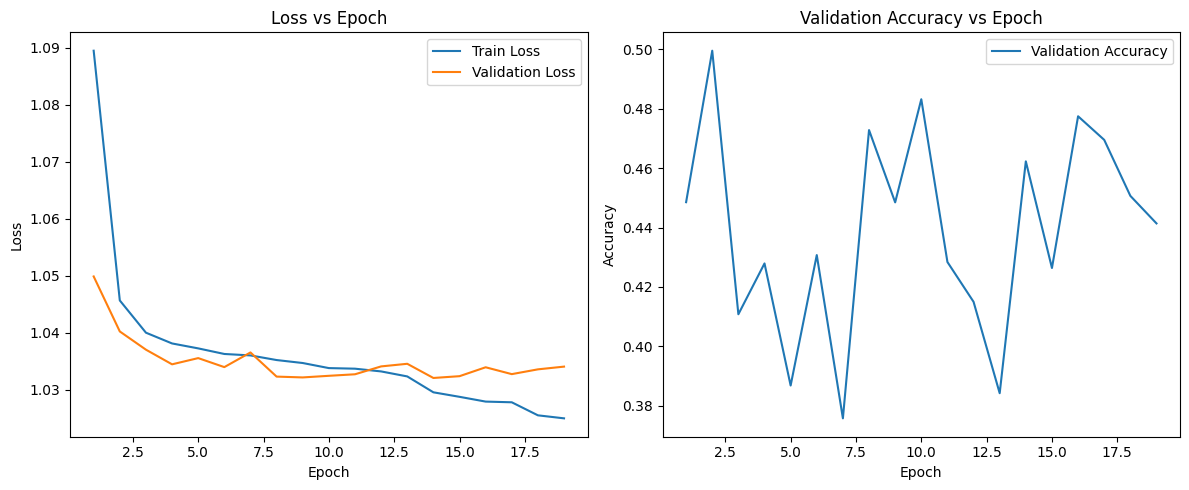

Confusion Matrix:
 [[39465 30041 27923]
 [20228 43444 26762]
 [ 1717  2381  3264]]

Classification Report:
              precision    recall  f1-score   support

       White       0.64      0.41      0.50     97429
       Black       0.57      0.48      0.52     90434
        Draw       0.06      0.44      0.10      7362

    accuracy                           0.44    195225
   macro avg       0.42      0.44      0.37    195225
weighted avg       0.59      0.44      0.49    195225



In [3]:
import numpy as np      
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Model class
class ChessModel(nn.Module):
    def __init__(self, tabular_size, seq_num_size, board_ch, H, W,
                 cnn_embed=64, lstm_hidden=64):
        super().__init__()
        self.tab_net = nn.Sequential(
            nn.Linear(tabular_size, 64),
            nn.ReLU()
        )
        self.cnn = nn.Sequential(
            nn.Conv2d(board_ch, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, cnn_embed), nn.ReLU()
        )
        self.lstm = nn.LSTM(
            input_size=cnn_embed + seq_num_size,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 + 2*lstm_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, tab, num_seq, img_seq):
        B, S, C, H, W = img_seq.shape
        t = self.tab_net(tab)                        
        x = img_seq.view(B*S, C, H, W)
        e = self.cnn(x).view(B, S, -1)             
        seq_in = torch.cat([num_seq, e], dim=2)   
        _, (h_n, _) = self.lstm(seq_in)         
        l = torch.cat([h_n[0], h_n[1]], dim=1)  
        out = torch.cat([t, l], dim=1)             
        return self.classifier(out)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_tab, sample_seq, sample_img, _ = next(iter(train_loader))
_, S, C, H, W = sample_img.shape

model = ChessModel(
    tabular_size=sample_tab.shape[1],
    seq_num_size=sample_seq.shape[2],
    board_ch=C, H=H, W=W
).to(device)

raw_labels = [dataset.result_map[g['result']] for g in raw_games]
class_counts = np.bincount(raw_labels)
cw = 1.0 / class_counts
cw = cw / cw.sum() * len(class_counts)
weights = torch.FloatTensor(cw).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Model trainng method
def train_model(model, train_loader, val_loader, epochs=50):
    best_loss = float('inf')
    stop_counter = 0
    patience = 10 
    train_losses = []
    val_losses = []
    val_accuracies = []

    for ep in range(1, epochs+1):
        model.train()
        total_train = 0
        for t, s, i, y in tqdm(train_loader, desc=f"Epoch {ep} train"):
            t, s, i, y = t.to(device), s.to(device), i.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(t, s, i)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_train += loss.item() * t.size(0)
        avg_train = total_train / len(train_loader.dataset)

        model.eval()
        total_val = correct = 0
        with torch.no_grad():
            for t, s, i, y in tqdm(val_loader, desc=f"Epoch {ep} val"):
                t, s, i, y = t.to(device), s.to(device), i.to(device), y.to(device)
                out = model(t, s, i)
                loss = criterion(out, y)
                total_val += loss.item() * t.size(0)
                correct += (out.argmax(1) == y).sum().item()
        avg_val = total_val / len(val_loader.dataset)
        acc_val = correct / len(val_loader.dataset)

        print(f"Ep{ep} Train: {avg_train:.4f} | Val: {avg_val:.4f}, Acc: {acc_val:.4f}")
        
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        val_accuracies.append(acc_val)

        scheduler.step(avg_val)

        if avg_val < best_loss - 1e-4:
            best_loss = avg_val
            stop_counter = 0
            torch.save(model.state_dict(), f'best_epoch{ep}.pth')
            print("  New best model saved.")
        else:
            stop_counter += 1
            if stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plotting Losses and Accuracy
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Evaluating Model 
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for t, s, i, y in loader:
            t, s, i = t.to(device), s.to(device), i.to(device)
            out = model(t, s, i)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
          target_names=['White','Black','Draw']))

# Training 
model = train_model(model, train_loader, test_loader, epochs=50)
evaluate_model(model, test_loader)
